In [2]:
import numpy as np
import trackpy as tp
import random
import pandas as pd
import skimage.measure
import matplotlib.pyplot as plt
import glob
import tifffile
from organoid_tracking import organoid_tracking

## analyzing an image sequence

we get the organoid properties sequentially and then link the individual organoids together using trackpy.

In [7]:
path_to_imgs = '/Users/gustaveronteix/Documents/Code/Jaulinlab/Data/Clemence_project/masks_CNV029/PEG_CT'
fnames = glob.glob(os.path.join(path_to_imgs, '*/*.tif'))

Frame 41: 1 trajectories present.


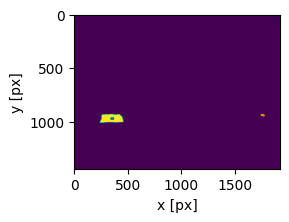

In [8]:
from itertools import repeat
output_directory = ''
movie_frames = map(organoid_tracking.movie_analysis, fnames, repeat(output_directory))

file_data = pd.DataFrame()
file_data = pd.concat(list(movie_frames), 
                      ignore_index=True)
file_data['unique_organoid'] = file_data['particle'].astype(str) + ':' + file_data['movie_name']

In [9]:
organoid_statistics = pd.DataFrame(columns = ['movie_name', 'particle'])

for single_particle in file_data.unique_organoid.unique():

    unique_organoid_frame = file_data[file_data.unique_organoid == single_particle].sort_values('frame')
    
    assert len(unique_organoid_frame.movie_name.unique()) == 1
    assert len(unique_organoid_frame.particle.unique()) == 1

    single_organoid_statistics = pd.DataFrame(columns = ['movie_name',
                                                         'particle',
                                                         'unique_organoid',
                                                         'velocity_std',
                                                         'velocity_mean',
                                                         'perimeter',
                                                         'area',
                                                         'circularity'])

    single_organoid_statistics.loc[0, 'movie_name'] = unique_organoid_frame.movie_name.unique()[0]
    single_organoid_statistics.loc[0, 'particle'] = unique_organoid_frame.particle.unique()[0]
    single_organoid_statistics.loc[0, 'unique_organoid'] = single_particle

    single_organoid_statistics.loc[0, 'cumulative_displacement'] = unique_organoid_frame['cumulative_displacement'].max()
    single_organoid_statistics.loc[0, 'absolute_displacement'] = unique_organoid_frame.loc[unique_organoid_frame.index.max(), 'absolute_displacement']
    single_organoid_statistics.loc[0, 'velocity_std'] = unique_organoid_frame['velocity'].std()
    single_organoid_statistics.loc[0, 'velocity_mean'] = unique_organoid_frame['velocity'].mean()
    single_organoid_statistics.loc[0, 'perimeter'] = unique_organoid_frame['perimeter'].mean()
    single_organoid_statistics.loc[0, 'area'] = unique_organoid_frame['area'].mean()
    single_organoid_statistics.loc[0, 'circularity'] = 4*np.pi*(unique_organoid_frame['area']/unique_organoid_frame['perimeter']**2).mean()

    organoid_statistics = pd.concat([organoid_statistics, single_organoid_statistics])



## Saving the results

We save the resulting data in a specific subfolder `organoid_statistics` that is contained in the same directory as the images.

In [10]:
savedir = os.path.join(path_to_imgs, 'organoid_statistics')

if not os.path.exists(savedir):
    os.makedirs(savedir)

organoid_statistics.to_csv(os.path.join(savedir, 'organoid_statistics.csv'), index = False)
file_data.to_csv(os.path.join(savedir, 'velocity_stats.csv'), index = False)